<a href="https://colab.research.google.com/github/ArindamBanerji/wip-experiments/blob/master/misc/TS_Image_architectures_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 50.2 MB/s eta 0:00:00


In [2]:
!pip install yfinance

In [3]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
from torch.autograd import Variable
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader,ConcatDataset, TensorDataset,Subset,Dataset
from sklearn.model_selection import train_test_split
import warnings
import pandas as pd
import yfinance as yf
import datetime
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField as GADF
import plotly.graph_objs as go
import plotly.io as pio
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from pyts.image import GramianAngularField
from torchvision.models import resnet18
import torch.optim as optim

In [4]:
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


**Import DataSets**

In [5]:
# create function that takes ticker symbol, start and end daates and returns dataset
def get_data(ticker, start_date, end_date):
  data = yf.download(ticker, start=start_date, end=end_date, interval='1h')
  return data

In [6]:
# define function to show sample of returned data
def show_sample(data):
  print(data.head())
  print(data.tail())
  print(data.describe())
  print(data.info())

In [7]:
start_date = '2023-05-11'
end_date = '2024-06-10'
ticker = 'AAPL'
data = get_data(ticker, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


In [8]:
# shiw sample data
show_sample(data)

                                 Open        High         Low       Close  \
Datetime                                                                    
2023-05-11 09:30:00-04:00  173.850006  173.960007  172.169998  172.669998   
2023-05-11 10:30:00-04:00  172.669998  173.699997  172.300003  173.699997   
2023-05-11 11:30:00-04:00  173.695007  173.914993  173.259995  173.660004   
2023-05-11 12:30:00-04:00  173.669998  174.024994  173.380005  173.470001   
2023-05-11 13:30:00-04:00  173.470001  174.000000  173.059998  173.990097   

                            Adj Close    Volume  
Datetime                                         
2023-05-11 09:30:00-04:00  172.669998  11552802  
2023-05-11 10:30:00-04:00  173.699997   6827208  
2023-05-11 11:30:00-04:00  173.660004   5325734  
2023-05-11 12:30:00-04:00  173.470001   4415832  
2023-05-11 13:30:00-04:00  173.990097   4089255  
                                 Open        High         Low       Close  \
Datetime                         

**Create GADF images from Time Series**

In [27]:
def create_gaf_images(data, image_size=28):
    num_days = len(data) // (image_size)
    data = data[:num_days*image_size].reshape(num_days, image_size)
    close_prices=[]
    for i in range(num_days):
        close_prices.append(np.mean(data[i]))
    gadf = GADF(image_size=image_size)
    gadf_images= gadf.fit_transform(data)
    return gadf_images,close_prices


In [28]:
# def function to return np.array of a particular column of dataframe
def get_column(data, column_name):
    return np.array(data[column_name])

In [29]:
def get_for_whole(data):
    images=[]
    prices=[]
    data1= data.drop(columns=['Volume'])
    for idx, i in enumerate(data1.columns):
      if(idx<1 or idx>3):
        continue
      close= np.array(data1[i])
      gaf_images,close_prices= create_gaf_images(close,30)
      images.append(gaf_images)
      if(i=='Close'):
        prices.append(close_prices)
    images= np.transpose(images, (1, 0, 2, 3))
    return np.array(images), prices


1889
(62, 30, 30)


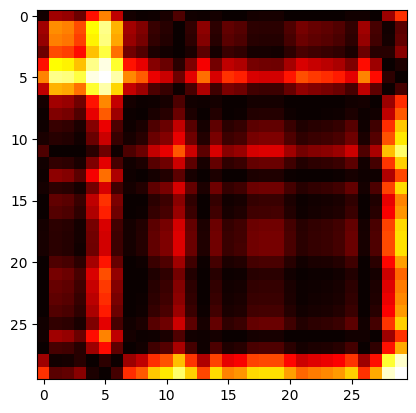

In [30]:
close= get_column(data,'Close')
print(len(close))

gaf_images,close_prices= create_gaf_images(close,30)
plt.imshow(gaf_images[0],cmap='hot')
print(gaf_images.shape)


In [34]:
def indexed_image (images, index) :
    image= images[index]
    image= np.transpose(image, (1, 2, 0))
    plt.imshow(image)

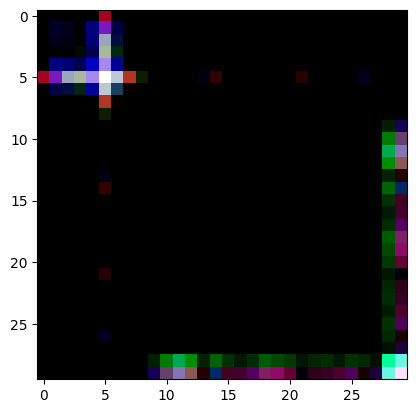

In [35]:
images, prices= get_for_whole(data)

indexed_image(images, 0)

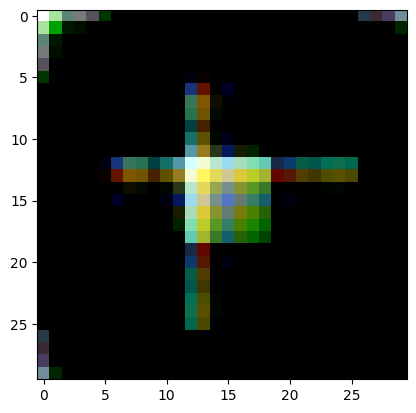

In [36]:
indexed_image(images, 1)

** Generate Encodings usng CNNs on GADF images**

In [38]:
# This function is used to generate random noise image
def generate_noise_image():
    return torch.rand((1, 3, 224, 224))

# function to preprocess input image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)
    return image

# function to get embeddings from ResNet model
def get_resnet_embeddings(image_path=None):

    resnet = models.resnet50(pretrained=True)
    resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    if image_path is None:
        image = generate_noise_image()
    else:
        image = preprocess_image(image_path)
    embeddings = resnet(image)
    return embeddings

# function to get embeddings from DenseNet model
def get_densenet_embeddings(image_path=None):
    densenet = models.densenet121(pretrained=True)
    densenet = torch.nn.Sequential(*list(densenet.children())[:-1])
    if image_path is None:
        image = generate_noise_image()
    else:
        image = preprocess_image(image_path)
    embeddings = densenet(image)
    return embeddings

**Simple LSTM**

In [39]:
class LstmNet(nn.Module):
    def __init__(self,input_size,hidden_size,layers,output_size):
        super(LstmNet,self).__init__()
        self.layers = layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=layers, batch_first=True)

        self.fc1 = nn.Linear(hidden_size, output_size)
        # self.fc2 = nn.Linear(10,output_size)
    def forward(self,x):
        # print(x.shape)
        h0 = Variable(torch.zeros(self.layers, x.size(0), self.hidden_size)).to(device)

        c0 = Variable(torch.zeros(self.layers, x.size(0), self.hidden_size)).to(device)
        out, (h_out, c_out) = self.lstm(x,(h0,c0))
        # print(out.shape,h_out.shape,c_out.shape)
        out = self.fc1(out[:,-1,:])
        return out.squeeze(1)


In [40]:
def prepare_dataset(data,length):
    x = []
    y = []
    for i in range(len(data)-length-1):
        x.append(data[i:i+length])
        y.append(data[i+length])
    return np.array(x),np.array(y)

def train_test_split(X,Y,percent):
    per = percent/100
    sz = len(X)
    xtrain = torch.Tensor(X[:int(sz*per)])
    ytrain = torch.Tensor(Y[:int(sz*per)])
    xtest = torch.Tensor(X[int(sz*per):])
    ytest = torch.Tensor(Y[int(sz*per):])
    return xtrain,ytrain,xtest,ytest

class DataPrep(Dataset):
  def __init__(self, inputs, targets):
      self.inputs = inputs
      self.targets = targets
  def __len__(self):
      return len(self.inputs)

  def __getitem__(self, index):
      X = self.inputs[index]
      Y = self.targets[index]
      return X, Y

In [41]:
# define function to encapsulate the whole train-prediction cycle

def train_predict (data) :
    scaler = StandardScaler()
    values = scaler.fit_transform(data['Close'].values.reshape(-1,1))
    seq_len = 40
    data_inp,data_tar = prepare_dataset(values,seq_len)
    xtrain,ytrain,xtest,ytest = train_test_split(data_inp,data_tar,80)

    traindata = DataPrep(xtrain,ytrain)
    testdata = DataPrep(xtest,ytest)
    batch_size = 32
    trainset = DataLoader(traindata,batch_size = batch_size,shuffle = True)
    testset = DataLoader(testdata,batch_size = batch_size,shuffle = True)
    for xbatch,ybatch in trainset:
        print(xbatch.shape,ybatch.shape)
        break


    train_losses = []
    test_losses = []
    input_sz = 1
    hidden_sz = 200
    output_sz = 1
    layers = 2
    model = LstmNet(input_sz,hidden_sz,layers,output_sz).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.00001)
    for epoch in range(1000):
        batch_loss = 0
        # correct = 0
        for xbatch,ybatch in trainset:
            xbatch,ybatch = xbatch.to(device),ybatch.to(device)
            out = model(xbatch)
            # print(ybatch.shape,out.shape)
            loss = criterion(out, ybatch.squeeze(1))
            loss.backward()
            optimizer.step()
            batch_loss += loss.item()
            # break

        train_loss = batch_loss/len(trainset)
        batch_loss = 0
        with torch.no_grad():
            for xbatch,ybatch in testset:
                xbatch,ybatch = xbatch.to(device),ybatch.to(device)
                out = model(xbatch)
                loss = criterion(out, ybatch.squeeze(1))
                batch_loss += loss.item()
        test_loss = batch_loss/len(testset)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        if(epoch%10==9):
            print("Epoch: ", epoch+1, "|", "Train Loss : ", "{:.6f}".format(train_loss), "|", "Test Loss : ", "{:.6f}".format(test_loss))

    return xtrain, ytrain, xtest, ytest, model



In [42]:
# define the prdict function for lstm
def predict(xtrain, ytrain, xtest, ytest, model):
  train_pred = model(xtrain.to(device)).cpu().data.numpy()
  train_actual = ytrain.data.numpy()
  test_pred = model(xtest.to(device)).cpu().data.numpy()
  test_actual = ytest.data.numpy()

  pred = np.concatenate((train_pred,test_pred))
  # pred = scaler.inverse_transform(pred)
  actual = np.concatenate((train_actual,test_actual)).squeeze()
  # actual = scaler.inverse_transform(pred)
  print(pred.shape)
  print(actual.shape)

  return pred, actual, train_pred, test_actual

In [43]:
# define function to display results
def display_results(pred, actual, train_pred, test_actual) :
    trace1 = go.Scatter(x = [(i+1) for i in range(len(pred))],y = pred, name='Predicted Data')
    trace2 = go.Scatter(x = [(i+1) for i in range(len(actual))],y = actual, name='Actual data')

    datas = [trace1,trace2]

    layout = go.Layout(title='Prediction for 80:20 split Normal LSTM')
    fig = go.Figure(data=datas, layout=layout)
    fig.add_vline(x=len(train_pred), line_width=1, line_dash="dash", line_color="red")

    fig.show()



In [44]:
def run_lstm (data) :
  xtrain, ytrain, xtest, ytest, model = train_predict(data)
  pred, actual, train_pred, test_actual = predict(xtrain, ytrain, xtest, ytest, model)
  display_results(pred, actual, train_pred, test_actual)


In [45]:
run_lstm(data)

torch.Size([32, 40, 1]) torch.Size([32, 1])
Epoch:  10 | Train Loss :  0.809342 | Test Loss :  1.680610
Epoch:  20 | Train Loss :  0.451878 | Test Loss :  0.745365
Epoch:  30 | Train Loss :  0.416897 | Test Loss :  0.359044
Epoch:  40 | Train Loss :  0.462233 | Test Loss :  0.909128
Epoch:  50 | Train Loss :  0.021506 | Test Loss :  0.044674
Epoch:  60 | Train Loss :  0.033191 | Test Loss :  0.030295
Epoch:  70 | Train Loss :  0.321023 | Test Loss :  0.565847
Epoch:  80 | Train Loss :  0.032831 | Test Loss :  0.036244
Epoch:  90 | Train Loss :  0.162459 | Test Loss :  0.243596
Epoch:  100 | Train Loss :  0.167400 | Test Loss :  0.386995
Epoch:  110 | Train Loss :  0.114973 | Test Loss :  0.126349
Epoch:  120 | Train Loss :  0.125905 | Test Loss :  0.162482
Epoch:  130 | Train Loss :  0.084055 | Test Loss :  0.093053
Epoch:  140 | Train Loss :  0.107412 | Test Loss :  0.190554
Epoch:  150 | Train Loss :  0.161661 | Test Loss :  0.261309
Epoch:  160 | Train Loss :  0.064869 | Test Loss :

**CNN on GADF images**

In [46]:
def generate_images_hack (data, img_sz, data_sz) :

    values = data['Close'].values.reshape(1,-1)
    images = []
    labels = []
    image_size = img_sz
    data_size = data_sz
    # method = 'difference'
    method = 'summation'
    sample_range = (0, 1)

    for i in range(len(values[0])-data_size-33):
        gaf = GramianAngularField(image_size=image_size, method=method, sample_range=sample_range)
        gadf_image  = gaf.fit_transform(values[:,i:i+32])
        images.append(gadf_image)
        labels.append(values[:,i+32+1])
    images = np.array(images).astype(np.float32)
    labels = np.array(labels)

    return images, labels

In [48]:
def generate_images (data, img_sz, data_sz) :

    values = data['Close'].values.reshape(1,-1)
    images = []
    labels = []
    image_size = img_sz
    data_size = data_sz
    # method = 'difference'
    method = 'summation'
    sample_range = (0, 1)

    for i in range(len(values[0])-data_size-1):
        gaf = GramianAngularField(image_size=image_size, method=method, sample_range=sample_range)
        gadf_image  = gaf.fit_transform(values[:,i:i+data_size])
        images.append(gadf_image)
        labels.append(values[:,i+data_size+1])
    images = np.array(images).astype(np.float32)
    labels = np.array(labels)

    return images, labels

In [49]:
def display_images ( images, labels ) :
    fig, ax = plt.subplots(figsize =(10, 7))
    ax.hist(labels, bins = 20)
    plt.show()
    return plt

In [50]:
class DataPrep(Dataset):
  def __init__(self, inputs, targets):
      self.inputs = inputs
      self.targets = targets
  def __len__(self):
      return len(self.inputs)

  def __getitem__(self, index):
      X = self.inputs[index]
      Y = self.targets[index]
      return X, Y
def split_prepare_data(dataset, batch_size=32, test_size=0.2):

    num_samples = len(dataset)
    num_test_samples = int(test_size * num_samples)
    num_train_samples = num_samples - num_test_samples
    indices = np.random.permutation(num_samples)
    train_indices = indices[:num_train_samples]
    #print(train_indices)
    test_indices = indices[num_train_samples:]
    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
    test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    return train_loader, test_loader


def prepare_dataset(input,labels,length):
    x = []
    y = []
    for i in range(len(input)-length-1):
        x.append(input[i:i+length])
        y.append(labels[i+length])
    return np.array(x),np.array(y)

def prepare_dataset_fromone(input,length):
    x = []
    y = []
    for i in range(len(input)-length-1):
        x.append(input[i:i+length])
        y.append(input[i+length])
    return np.array(x),np.array(y)

In [52]:
class GAFModel(nn.Module):
    def __init__(self, input_channels, output_size):
        super(GAFModel, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 3, kernel_size=3, stride=1, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.resnet = resnet18(weights = True)
        # self.fc1 = nn.Linear(32 * 8 * 8, 256)
        # self.fc1 = nn.Linear(1000,256)
        # self.fc2 = nn.Linear(256,32)
        self.fc3 = nn.Linear(1000, output_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = self.resnet(x)
        # x = x.view(-1, 32 * 8 * 8)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [54]:
def train_predict_cnn (data) :
      images, labels = generate_images_hack (data, 32, 32)
      scaler = StandardScaler()
      labels = scaler.fit_transform(labels).reshape(-1,).astype(np.float32)

      dataset = DataPrep(images,labels)
      train_loader,test_loader = split_prepare_data(dataset)
      model = GAFModel(input_channels=1, output_size=1).to(device)
      criterion = nn.MSELoss()
      optimizer = optim.Adam(model.parameters(), lr=0.001)
      num_epochs = 10
      for epoch in range(num_epochs):
          train_loss = 0.0
          pbar = tqdm(total = len(train_loader))
          for xbatch,ybatch in train_loader:
              optimizer.zero_grad()
              xbatch, ybatch = xbatch.to(device),ybatch.to(device)
              output = model(xbatch)
              loss = criterion(output,ybatch)+torch.sum(ybatch)
              loss.backward()
              optimizer.step()
              train_loss += loss.item()
              pbar.update(1)
          train_loss /= len(train_loader)
          pbar.close()

          test_loss = 0.0
          with torch.no_grad():
              for xbatch,ybatch in test_loader:
                  xbatch, ybatch = xbatch.to(device),ybatch.to(device)
                  output = model(xbatch)
                  loss = criterion(output,ybatch)
                  test_loss += loss.item()
              test_loss /= len(test_loader)

          print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Testing Loss: {test_loss:.4f}")

      pred = model(torch.Tensor(images).to(device)).cpu().data.numpy().squeeze()

      return pred, labels

In [55]:
def predict_cnn (labels, pred) :

    trace1 = go.Scatter(x = [(i+1) for i in range(len(pred))],y = pred, name='Predicted Data')
    trace2 = go.Scatter(x = [(i+1) for i in range(len(labels))],y = labels, name='Actual data')

    plot_data = [trace1,trace2]

    layout = go.Layout(title='Prediction for 80:20 split Using CNN')
    fig = go.Figure(data=plot_data, layout=layout)
    # fig.add_vline(x=len(train_pred), line_width=1, line_dash="dash", line_color="red")

    fig.show()

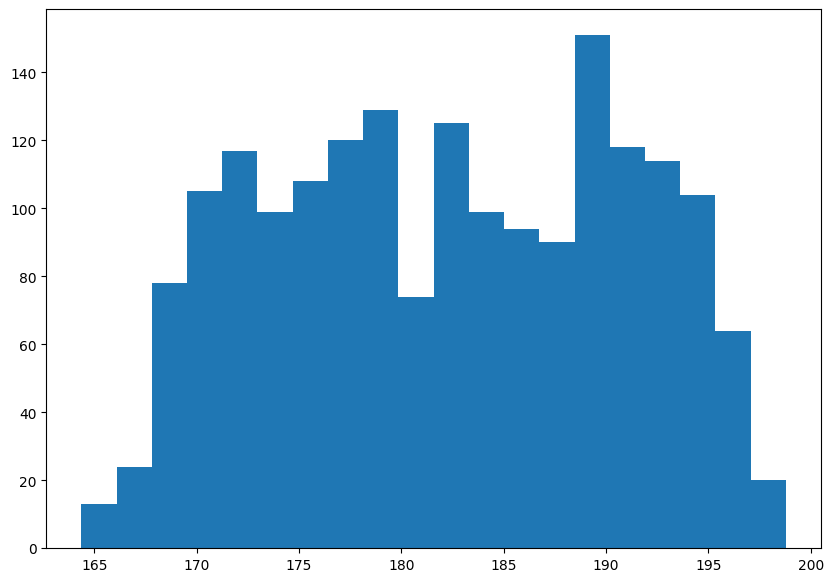

In [60]:
# generae images and labels
images, labels = generate_images_hack (data, 10, 10)

plt = display_images ( images, labels )


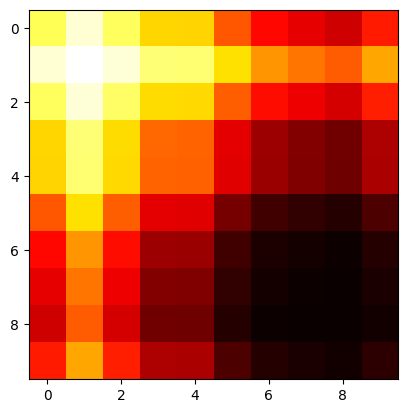

In [61]:
plt.imshow(images[40].transpose(1,2,0),cmap='hot')

In [64]:
# generae images and labels
pred, labels = train_predict_cnn(data)

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1/10 - Training Loss: 3.7310 - Testing Loss: 2.3515


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2/10 - Training Loss: 2.7191 - Testing Loss: 2.0352


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3/10 - Training Loss: 2.0838 - Testing Loss: 4.7244


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4/10 - Training Loss: 1.9317 - Testing Loss: 2.3394


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5/10 - Training Loss: 1.8435 - Testing Loss: 1.2514


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6/10 - Training Loss: 1.2276 - Testing Loss: 1.3853


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7/10 - Training Loss: 1.2838 - Testing Loss: 1.2854


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 8/10 - Training Loss: 1.0567 - Testing Loss: 1.2558


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9/10 - Training Loss: 0.9359 - Testing Loss: 1.1632


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10/10 - Training Loss: 0.9727 - Testing Loss: 1.1910


In [65]:
actual = labels
print(pred.shape)
print(actual.shape)

predict_cnn (labels, pred)

(1824,)
(1824,)


**LSTM IMAGE**

In [ ]:
def gen_lstm_images (data) :
    values = data['Close'].values.reshape(1,-1)
    images = []
    labels = []
    image_size = 32
    data_size = 32
    # method = 'difference'
    method = 'summation'
    sample_range = (0, 1)

    for i in range(len(values[0])-data_size-1):
        gaf = GramianAngularField(image_size=image_size, method=method, sample_range=sample_range)
        gadf_image  = gaf.fit_transform(values[:,i:i+data_size])
        images.append(gadf_image)
        labels.append(values[:,i+data_size+1])
    images = np.array(images).astype(np.float32).reshape(-1,image_size*image_size)

    return images, labels

In [ ]:
class ImageLSTMNet(nn.Module):
    def __init__(self,input_size,hidden_size,layers,output_size):
        super(ImageLSTMNet,self).__init__()
        self.layers = layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=layers, batch_first=True)

        self.fc1 = nn.Linear(hidden_size, output_size)

    def forward(self,x):
        # print(x.shape)
        h0 = Variable(torch.zeros(self.layers, x.size(0), self.hidden_size)).to(device)

        c0 = Variable(torch.zeros(self.layers, x.size(0), self.hidden_size)).to(device)
        out, (h_out, c_out) = self.lstm(x,(h0,c0))
        # print(out.shape,h_out.shape,c_out.shape)
        out = self.fc1(out[:,-1,:])
        return out.squeeze(1)

In [ ]:
gen_lstm_images_tarin (data, 32 * 32, 2048, 1, 1)

In [ ]:
def gen_lstm_images_train ( data, inp_sz, hidden_sz, output_sz, layers) :

    print(images.shape,labels.shape)
    seq_images,seq_labels = prepare_dataset(images,labels,length = 40)
    print(seq_images.shape,labels.shape)

    dataset = DataPrep(seq_images,seq_labels)
    train_loader,test_loader = split_prepare_data(dataset,batch_size = 32)

    print(dataset[0][0].shape)

    for xbatch,ybatch in train_loader:
    print(xbatch.shape,ybatch.shape)
    break

    train_losses = []
    test_losses = []
    input_sz = inp_sz
    hidden_sz = hidden_sz
    output_sz = output_sz
    layers = layers

    LSTMmodel = ImageLSTMNet(input_sz,hidden_sz,layers,output_sz).to(device)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(LSTMmodel.parameters(), lr=0.0001)
    num_epochs = 10
    for epoch in range(num_epochs):
        train_loss = 0.0
        pbar = tqdm(total = len(train_loader))
        for xbatch,ybatch in train_loader:
            optimizer.zero_grad()
            xbatch, ybatch = xbatch.to(device),ybatch.to(device)
            output = LSTMmodel(xbatch)
            loss = criterion(output,ybatch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            pbar.update(1)
        train_loss /= len(train_loader)
        pbar.close()

        test_loss = 0.0
        with torch.no_grad():
            for xbatch,ybatch in test_loader:
                xbatch, ybatch = xbatch.to(device),ybatch.to(device)
                output = LSTMmodel(xbatch)
                loss = criterion(output,ybatch)
                test_loss += loss.item()
            test_loss /= len(test_loader)

        print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Testing Loss: {test_loss:.4f}")

    pred = LSTMmodel(torch.Tensor(seq_images).to(device)).cpu().data.numpy().squeeze()

In [ ]:
scaler = StandardScaler()
labels = scaler.fit_transform(labels).reshape(-1,).astype(np.float32)
plt.imshow(images[0].reshape(32,32))

print(images.shape,labels.shape)